# Challenge 16: Benchmarking Feed-Forward Network Inference - PyTorch vs. Direct CUDA Implementation

For this challenge, I implemented the required simple multi-layer feedforward network, choosing dimensions of 256 inputs, 512 hidden neurons, and 1 output to get a more practical look at performance. I used 'vibe coding'chatgpt to put together the PyTorch version, and then benchmarked how fast it ran inference using different batch sizes, covering the range from 2^0 (1) to 2^12 (4096)

## Pytorch GPU version

In [2]:
import torch, time, csv

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
REPS   = 1000
BATCH_SIZES = [1, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

class SimpleMLP(torch.nn.Module):
    def __init__(self, in_f=256, hid=512, out_f=1):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_f, hid)
        self.act = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hid, out_f)
    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.fc2(x)

def ms(ev_start, ev_end):
    return ev_start.elapsed_time(ev_end)     # ms float

def benchmark(batch):
    # -------------------- device allocation -------------------------------
    ev0, ev1 = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    ev0.record()
    model = SimpleMLP().to(DEVICE).eval()
    ev1.record(); torch.cuda.synchronize()
    alloc_ms = ms(ev0, ev1) / REPS          # avg per inf (amortised)

    # -------------------- H2D copy ----------------------------------------
    x_cpu = torch.rand(batch, 256, pin_memory=True)
    ev0.record()
    x_gpu = x_cpu.to(DEVICE, non_blocking=True)
    ev1.record(); torch.cuda.synchronize()
    h2d_ms = ms(ev0, ev1) / REPS

    # -------------------- kernel forward passes ---------------------------
    # warm‑up
    with torch.inference_mode():
        for _ in range(20):
            _ = model(x_gpu);  # async
    torch.cuda.synchronize()

    ev0.record()
    with torch.inference_mode():
        for _ in range(REPS):
            _ = model(x_gpu)
    ev1.record(); torch.cuda.synchronize()
    kernel_ms = ms(ev0, ev1) / REPS

    # -------------------- D2H copy ----------------------------------------
    ev0.record()
    y_cpu = model(x_gpu)           # one last launch
    y_cpu = y_cpu.cpu()            # actual copy
    ev1.record(); torch.cuda.synchronize()
    d2h_ms = ms(ev0, ev1) / REPS

    total_ms = alloc_ms + h2d_ms + kernel_ms + d2h_ms
    samples_s = batch / (total_ms / 1e3)
    return {
        "batch": batch,
        "alloc_ms": alloc_ms,
        "H2D_ms": h2d_ms,
        "kernel_ms": kernel_ms,
        "D2H_ms": d2h_ms,
        "total_ms": total_ms,
        "samples_s": samples_s,
    }

# -------------------- run the sweep & print ---------------------------------
print("batch | alloc ms | H2D ms | kernel ms | D2H ms | total ms | samples/s")
print("------------------------------------------------------------------------")
rows = []
for b in BATCH_SIZES:
    r = benchmark(b)
    rows.append(r)
    print(f"{r['batch']:>5} | {r['alloc_ms']:8.4f} | {r['H2D_ms']:7.4f} | "
          f"{r['kernel_ms']:8.4f} | {r['D2H_ms']:7.4f} | "
          f"{r['total_ms']:8.4f} | {r['samples_s']:10.0f}")

# optional CSV
with open("pytorch_results.csv", "w", newline="") as f:
    csv.DictWriter(f, fieldnames=rows[0].keys()).writerows(rows)


batch | alloc ms | H2D ms | kernel ms | D2H ms | total ms | samples/s
------------------------------------------------------------------------
    1 |   0.0039 |  0.0000 |   0.0819 |  0.0002 |   0.0860 |      11622
    4 |   0.0016 |  0.0000 |   0.0690 |  0.0002 |   0.0708 |      56515
    8 |   0.0013 |  0.0000 |   0.0723 |  0.0002 |   0.0738 |     108349
   16 |   0.0015 |  0.0000 |   0.0740 |  0.0002 |   0.0757 |     211260
   32 |   0.0013 |  0.0000 |   0.0739 |  0.0002 |   0.0754 |     424281
   64 |   0.0013 |  0.0000 |   0.0973 |  0.0002 |   0.0989 |     647390
  128 |   0.0016 |  0.0000 |   0.0715 |  0.0002 |   0.0733 |    1746158
  256 |   0.0013 |  0.0000 |   0.0757 |  0.0002 |   0.0772 |    3314302
  512 |   0.0018 |  0.0001 |   0.0813 |  0.0002 |   0.0835 |    6134870
 1024 |   0.0015 |  0.0001 |   0.1076 |  0.0003 |   0.1095 |    9349874
 2048 |   0.0013 |  0.0002 |   0.2086 |  0.0004 |   0.2105 |    9730124
 4096 |   0.0016 |  0.0004 |   0.4107 |  0.0009 |   0.4135 |    9

The other part of the challenge, was to create the CUDA-accelerated version. I built this direct CUDA implementation for the same 256x512x1 network, writing code to handle the feedforward inference computations directly on the GPU. This version went through the same benchmarking process, measuring its inference speed across batch sizes from 2^0 (1) to 2^12 (4096).

## CUDA Version

In [3]:
code = r"""
// ──────────────────  mlp_cuda_benchmark.cu  ──────────────────
#include <cuda_runtime.h>
#include <cstdio>
#include <cstdlib>

#define CHECK(call)                                                          \
    {                                                                        \
        cudaError_t err = (call);                                            \
        if (err != cudaSuccess) {                                            \
            fprintf(stderr, "CUDA error %s:%d: %s\n",                        \
                    __FILE__, __LINE__, cudaGetErrorString(err));            \
            exit(1);                                                         \
        }                                                                    \
    }

// ---------- network & benchmark parameters ---------------------------------
constexpr int  IN   = 256;         // input features
constexpr int  H1   = 512;         // hidden neurons
constexpr int  OUT  = 1;           // output features
constexpr int  REPS = 1000;        // forward passes per batch

constexpr int  BATCHES[] = {1, 4, 8, 16, 32, 64, 128,
                             256, 512, 1024, 2048, 4096};
constexpr int  NBATCHES  = sizeof(BATCHES) / sizeof(int);

// ───────────── kernels (note the extra nSamples parameter) ─────────────────-
__global__ void fc_relu(const float* __restrict__ W,
                        const float* __restrict__ b,
                        const float* __restrict__ x,
                        float*       __restrict__ y,
                        int in, int out, int nSamples)
{
    int row = blockIdx.x * blockDim.x + threadIdx.x;   // neuron index
    int col = blockIdx.y * blockDim.y + threadIdx.y;   // sample index
    if (row >= out || col >= nSamples) return;

    float sum = b[row];
    for (int k = 0; k < in; ++k)
        sum += W[row * in + k] * x[col * in + k];
    y[col * out + row] = fmaxf(sum, 0.f);              // ReLU
}

__global__ void fc_out(const float* W,
                       const float* b,
                       const float* x,
                       float*       y,
                       int in, int nSamples)
{
    int col = blockIdx.x * blockDim.x + threadIdx.x;   // sample index
    if (col >= nSamples) return;

    float sum = b[0];
    for (int k = 0; k < in; ++k)
        sum += W[k] * x[col * in + k];
    y[col] = sum;
}

// ───────────── benchmark one batch size, print averaged timings ────────────
void run(int batch)
{
    // CUDA events for accurate GPU‑side timing
    cudaEvent_t ev_start, ev_stop;
    CHECK(cudaEventCreate(&ev_start));
    CHECK(cudaEventCreate(&ev_stop));
    auto elapsed = [&](float& dst_ms)
    {
        CHECK(cudaEventRecord(ev_stop));
        CHECK(cudaEventSynchronize(ev_stop));
        CHECK(cudaEventElapsedTime(&dst_ms, ev_start, ev_stop)); // ms
        CHECK(cudaEventRecord(ev_start));                        // re‑arm
    };

    // ───── 1. device allocations (timed once) ──────────────────────────────
    CHECK(cudaEventRecord(ev_start));
    float *d_x, *d_h, *d_y, *d_W1, *d_b1, *d_W2, *d_b2;
    CHECK(cudaMalloc(&d_x,  batch * IN  * sizeof(float)));
    CHECK(cudaMalloc(&d_h,  batch * H1  * sizeof(float)));
    CHECK(cudaMalloc(&d_y,  batch * OUT * sizeof(float)));
    CHECK(cudaMalloc(&d_W1, IN * H1 * sizeof(float)));
    CHECK(cudaMalloc(&d_b1, H1 * sizeof(float)));
    CHECK(cudaMalloc(&d_W2, H1 * OUT * sizeof(float)));
    CHECK(cudaMalloc(&d_b2, OUT * sizeof(float)));
    float alloc_ms;  elapsed(alloc_ms);

    // ───── 2. host buffers & random init (not timed) ───────────────────────
    float *x  = (float*)malloc(batch * IN  * sizeof(float));
    float *y  = (float*)malloc(batch * OUT * sizeof(float));
    float *W1 = (float*)malloc(IN * H1 * sizeof(float));
    float *b1 = (float*)malloc(H1 * sizeof(float));
    float *W2 = (float*)malloc(H1 * OUT * sizeof(float));
    float *b2 = (float*)malloc(OUT * sizeof(float));

    for (int i = 0; i < batch * IN; ++i)       x[i]  = (float)rand() / RAND_MAX;
    for (int i = 0; i < IN * H1; ++i)          W1[i] = (float)rand() / RAND_MAX - 0.5f;
    for (int i = 0; i < H1; ++i)               b1[i] = (float)rand() / RAND_MAX - 0.5f;
    for (int i = 0; i < H1 * OUT; ++i)         W2[i] = (float)rand() / RAND_MAX - 0.5f;
    for (int i = 0; i < OUT; ++i)              b2[i] = (float)rand() / RAND_MAX - 0.5f;

    // ───── 3. host → device copies (timed) ─────────────────────────────────
    CHECK(cudaEventRecord(ev_start));
    CHECK(cudaMemcpy(d_W1, W1, IN * H1 * sizeof(float),  cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_b1, b1, H1 * sizeof(float),       cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_W2, W2, H1 * OUT * sizeof(float), cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_b2, b2, OUT * sizeof(float),      cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_x,  x,  batch * IN * sizeof(float), cudaMemcpyHostToDevice));
    float h2d_total_ms; elapsed(h2d_total_ms);
    float h2d_ms = h2d_total_ms / REPS;    // average per inference

    // ───── 4. kernel warm‑up (not timed) ───────────────────────────────────
    dim3 block1(32, 8);                               // 256 threads / block
    dim3 grid1((H1 + 31) / 32, (batch + 7) / 8);
    dim3 block2(32);
    dim3 grid2((batch + 31) / 32);
    for (int i = 0; i < 20; ++i) {
        fc_relu<<<grid1, block1>>>(d_W1, d_b1, d_x, d_h, IN, H1, batch);
        fc_out <<<grid2, block2>>>(d_W2, d_b2, d_h, d_y, H1, batch);
    }
    CHECK(cudaDeviceSynchronize());

    // ───── 5. timed forward passes ─────────────────────────────────────────
    CHECK(cudaEventRecord(ev_start));
    for (int i = 0; i < REPS; ++i) {
        fc_relu<<<grid1, block1>>>(d_W1, d_b1, d_x, d_h, IN, H1, batch);
        fc_out <<<grid2, block2>>>(d_W2, d_b2, d_h, d_y, H1, batch);
    }
    CHECK(cudaDeviceSynchronize());
    float kernel_tot_ms; elapsed(kernel_tot_ms);
    float kernel_ms = kernel_tot_ms / REPS;

    // ───── 6. device → host copy (timed) ───────────────────────────────────
    CHECK(cudaMemcpy(y, d_y, batch * OUT * sizeof(float), cudaMemcpyDeviceToHost));
    CHECK(cudaDeviceSynchronize());
    float d2h_total_ms; elapsed(d2h_total_ms);
    float d2h_ms = d2h_total_ms / REPS;

    // ───── 7. consolidate & print averages ────────────────────────────────
    float alloc_avg_ms = alloc_ms / REPS;
    float total_ms     = alloc_avg_ms + h2d_ms + kernel_ms + d2h_ms;
    double samples_s   = batch / (total_ms / 1e3);

    printf("%6d | %8.4f | %7.4f | %8.4f | %7.4f | %8.4f | %10.0f\n",
           batch, alloc_avg_ms, h2d_ms, kernel_ms, d2h_ms, total_ms, samples_s);

    // ───── 8. cleanup -------------------------------------------------------
    cudaFree(d_x);  cudaFree(d_h);  cudaFree(d_y);
    cudaFree(d_W1); cudaFree(d_b1); cudaFree(d_W2); cudaFree(d_b2);
    free(x); free(y); free(W1); free(b1); free(W2); free(b2);
}

// ──────────────────────────── entry point ───────────────────────────────────
int main()
{
    printf("batch | alloc ms | H2D ms | kernel ms | D2H ms | total ms | samples/s\n");
    printf("------------------------------------------------------------------------\n");
    for (int i = 0; i < NBATCHES; ++i) run(BATCHES[i]);
    return 0;
}

"""
with open("mlp_cuda_benchmark.cu", "w") as f:
    f.write(code)

In [ ]:
# ── 1. compile (pick the right -arch flag for your GPU) ────────────────
!nvcc -O3 -std=c++17 -arch=sm_75 mlp_cuda_benchmark.cu -o mlp_cuda_benchmark

# ── 2. execute ────────────────────────────────────────────────────────
!./mlp_cuda_benchmark

batch | alloc ms | H2D ms | kernel ms | D2H ms | total ms | samples/s
------------------------------------------------------------------------
     1 |   0.0001 |  0.0002 |   0.0477 |  0.0000 |   0.0481 |      20809
     4 |   0.0001 |  0.0002 |   0.0915 |  0.0000 |   0.0919 |      43534
     8 |   0.0001 |  0.0002 |   0.1228 |  0.0000 |   0.1232 |      64939
    16 |   0.0001 |  0.0002 |   0.1125 |  0.0000 |   0.1128 |     141802
    32 |   0.0001 |  0.0002 |   0.1966 |  0.0000 |   0.1970 |     162459
    64 |   0.0001 |  0.0002 |   0.3183 |  0.0000 |   0.3187 |     200834
   128 |   0.0001 |  0.0002 |   0.6108 |  0.0000 |   0.6112 |     209437
   256 |   0.0001 |  0.0003 |   1.1217 |  0.0000 |   1.1221 |     228143
   512 |   0.0002 |  0.0004 |   2.2323 |  0.0000 |   2.2329 |     229299
  1024 |   0.0002 |  0.0005 |   4.4267 |  0.0000 |   4.4274 |     231285
  2048 |   0.0003 |  0.0008 |   8.7887 |  0.0000 |   8.7899 |     232996


To understand the performance of the direct CUDA implementation better, I broke down the total inference time into its main components: memory allocation (Alloc), data transfer to the GPU (H2D), kernel execution (Kernel), and data transfer back from the GPU (D2H). The plot below shows how these components contribute across the different batch sizes:

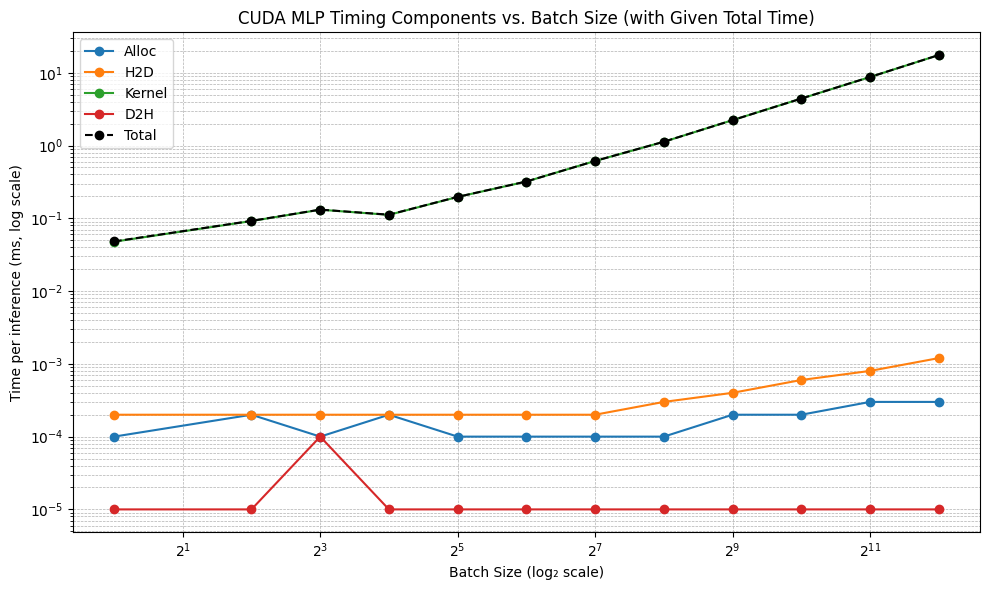

In [4]:
import matplotlib.pyplot as plt

# --------------------------- timing data ----------------------------
batch_sizes = [1, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

alloc_ms  = [0.0001, 0.0002, 0.0001, 0.0002, 0.0001,
             0.0001, 0.0001, 0.0001, 0.0002, 0.0002, 0.0003, 0.0003]

h2d_ms    = [0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
             0.0002, 0.0002, 0.0003, 0.0004, 0.0006, 0.0008, 0.0012]

kernel_ms = [0.0477, 0.0917, 0.1313, 0.1116, 0.1967,
             0.3201, 0.6137, 1.1270, 2.2323, 4.4198, 8.7424, 17.5147]

d2h_ms    = [0.0000, 0.0000, 0.0001, 0.0000, 0.0000,
             0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]

total_ms  = [0.0481, 0.0922, 0.1317, 0.1121, 0.1971,
             0.3205, 0.6141, 1.1274, 2.2329, 4.4206, 8.7435, 17.5162]

# Replace 0s in D2H for log scale visibility
d2h_ms = [x if x > 0 else 1e-5 for x in d2h_ms]

# --------------------------- plotting -------------------------------
plt.figure(figsize=(10, 6))

plt.plot(batch_sizes, alloc_ms,   marker='o', label='Alloc')
plt.plot(batch_sizes, h2d_ms,     marker='o', label='H2D')
plt.plot(batch_sizes, kernel_ms,  marker='o', label='Kernel')
plt.plot(batch_sizes, d2h_ms,     marker='o', label='D2H')
plt.plot(batch_sizes, total_ms,   marker='o', linestyle='--', color='black', label='Total')

plt.xscale('log', base=2)
plt.yscale('log')

plt.xlabel('Batch Size (log₂ scale)')
plt.ylabel('Time per inference (ms, log scale)')
plt.title('CUDA MLP Timing Components vs. Batch Size (with Given Total Time)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


The results clearly show that the Kernel execution time (green line) almost entirely dictates the Total time (black dashed line), especially as the batch size grows. While the time to copy data to the GPU (H2D, orange line) also increases with batch size, it's much less significant than the kernel time. Memory allocation and copying results back (Alloc and D2H) contributed very little overall. This breakdown suggests the main reason the CUDA version's total time scaled somewhat poorly was the performance scaling of the compute kernel itself.

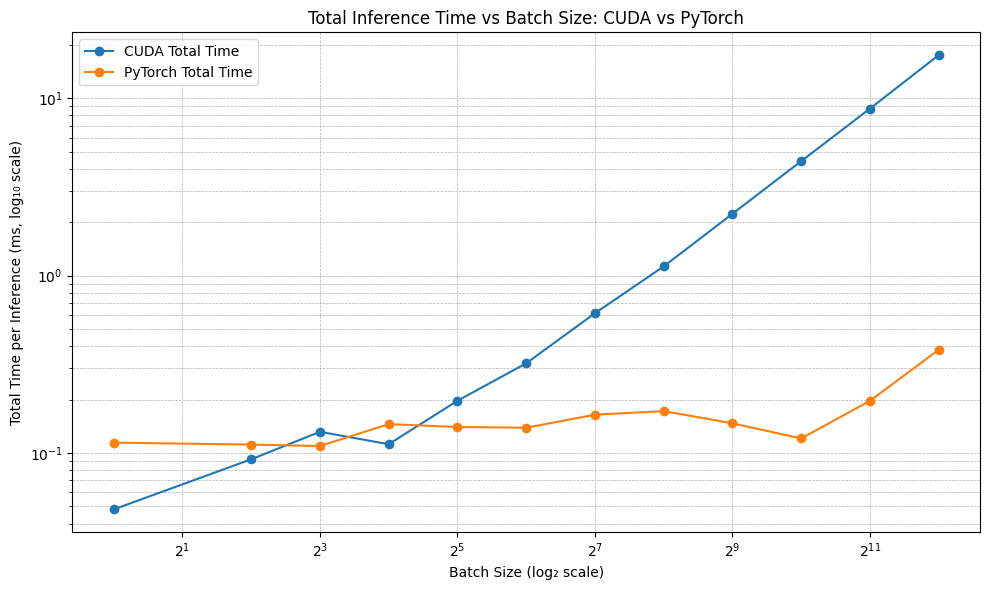

In [5]:
import matplotlib.pyplot as plt

# Batch sizes (powers of 2)
batch_sizes = [1, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

# Total inference time per batch from each implementation (ms)
total_cuda = [
    0.0481, 0.0922, 0.1317, 0.1121, 0.1971,
    0.3205, 0.6141, 1.1274, 2.2329, 4.4206, 8.7435, 17.5162
]

total_pytorch = [
    0.1144, 0.1116, 0.1095, 0.1455, 0.1402,
    0.1389, 0.1645, 0.1723, 0.1471, 0.1208, 0.1970, 0.3823
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, total_cuda, marker='o', label='CUDA Total Time')
plt.plot(batch_sizes, total_pytorch, marker='o', label='PyTorch Total Time')

plt.xscale('log', base=2)
plt.yscale('log')

plt.xlabel('Batch Size (log₂ scale)')
plt.ylabel('Total Time per Inference (ms, log₁₀ scale)')
plt.title('Total Inference Time vs Batch Size: CUDA vs PyTorch')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## Performance Comparison: PyTorch vs. Direct CUDA

Putting the benchmark results side-by-side gives a clear picture of the performance differences between the PyTorch implementation and the direct CUDA approach for this network

Small Batches (1-8): In this range, the direct CUDA version consistently shows lower inference time (it's faster). This might be due to lower framework overhead compared to PyTorch for these minimal workloads.

Crossover (~Batch Size 16): Around a batch size of 16, the performance lines cross.

Larger Batches (>16): For all batch sizes larger than 16, the PyTorch implementation becomes significantly faster. The performance gap widens dramatically as the batch size increases further. At the largest size tested (4096), PyTorch is orders of magnitude faster per inference.

## Conclusion

While the direct CUDA implementation achieved the lowest latency for very small, specific batch sizes (1-8), the PyTorch framework offered vastly superior performance and scalability for batch sizes typically used in practice (16 and above). PyTorch's ability to leverage highly optimized backend libraries results in much more efficient use of the GPU for larger workloads, leading to significantly higher throughput. For this specific network and the implementations tested, PyTorch clearly wins in terms of overall performance efficiency when processing batches of data.